**TP Filtres de Kalman d'ensemble : erreur d'échantillonnage et localisation**

L'objectif de ce TP est l'illustration de  l'impact des erreurs d'échantillonnage sur l'estimation de la matrice de covariance d'erreur de prévision ${\bf P}_f$, ainsi qu'une stratégie appelée localisation, permettant d'y remédier partiellement. 

*Sources*: ce TP s'inspire d'un notebook d'E. Cosme (UGA).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

**Estimation de matrice de covariance et erreur d'echantillonnage**

On considère un domaine péridique 1D, muni d'une grille régulière, ainsi que la solution d'une EDP ne faisant intervenir qu'une seule variable. On suppose avoir développé un système d'assimilation de données par filtrage de Kalman d'ensemble.

On suppose que la grille est faite de $40$ points de grille, ce qui fait que le vecteur d'état est de taille $40$, et la matrice d'erreur de prévision associée de taille $40 \times 40$. L'objectif est d'illustrer l'impact de la taille de l'ensemble, sur la qualité de l'estimation de cette matrice, en se donnant une matrice de référence, et la comparant à celles obtenues depuis echantillonnage. 

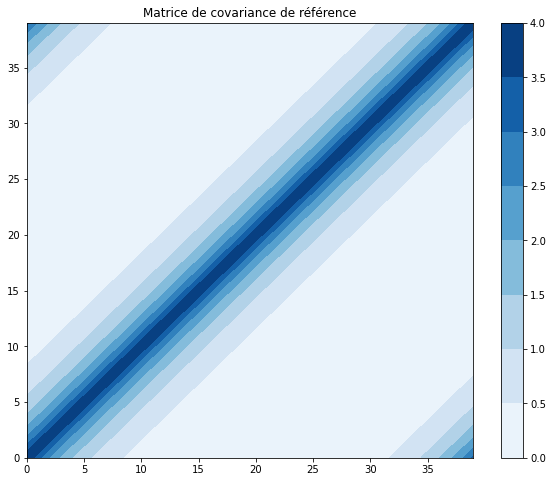

In [2]:
# Paramètres du domaine et de la grille
n_grid = 40                         
d_grid = 1.                          
L_grid = n_grid * d_grid             
x_grid = d_grid * np.arange(n_grid)  
X,Y = np.meshgrid(x_grid, x_grid)

# Matrice de référence P_t
dcut = 4.                            # longeur de corrélation
variance = 4.                        # variace
Pt = np.zeros((n_grid, n_grid))
for j in range(n_grid):
    for i in range(n_grid):
        rad = np.abs(x_grid[i]-x_grid[j])
        rad = np.min((rad,L_grid-rad))        # conditions aux frontières périodiques
        Pt[i,j] = variance * np.exp(-rad/dcut)
        
fig = plt.figure(figsize=(10,8))
im = plt.contourf(X, Y, Pt, cmap = cm.Blues)
plt.title('Matrice de covariance de référence')
fig.colorbar(im)

Soit ${\bf E}=[{\bf x}_1,..,{\bf x}_{Nens}]$ un ensemble de vecteur de distribution $\mathcal{N}({\bf 0},{\bf P}_t)$. On note $\displaystyle{\bar{\bf x}=\frac{1}{Nens}\sum_{i=1}^{Nens}{\bf x}_i}$ et ${\bf A}=[{\bf x}_1-\bar{\bf x},..,{\bf x}_{Nens}-\bar{\bf x}]$.

On considère l'estimateur de ${\bf P}_t$ :

$${\bf P}_e=\frac{1}{Nens-1}{\bf A}{\bf A}^T.$$

Visualiser ${\bf P}_e$ en fonction de $Nens$ et analyser l'évolution de l'erreur en norme de Frobenius.

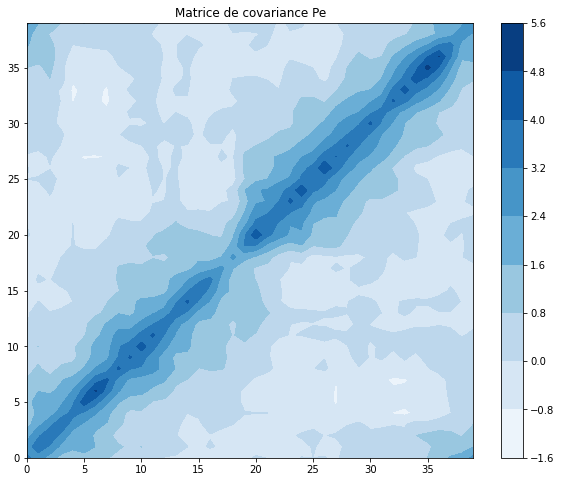

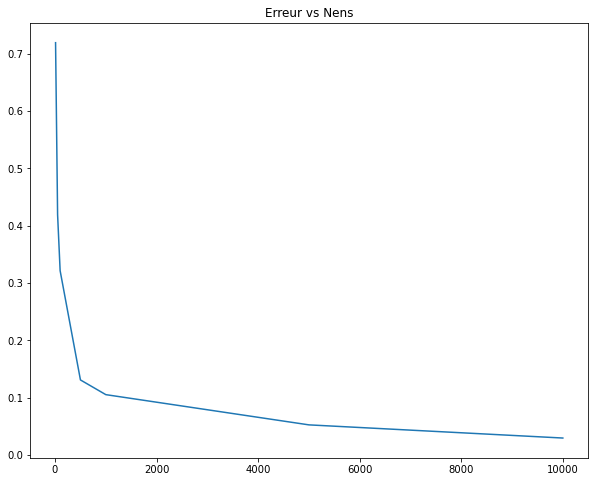

In [3]:
#Génération d'un esemble de taille Nens et calcul de Pe
## TO DO ##
def compute_Pe(Nens):
    mean = np.zeros(np.shape(Pt)[0])
    E = np.random.multivariate_normal(mean, Pt, size=Nens).T
    A = E - np.mean(E)
    return A@A.T/(Nens-1)
## End TO DO ##

# Visualisation de Pe
Nens=100
Pe=compute_Pe(Nens)
fig = plt.figure(figsize=(10,8))
im = plt.contourf(X, Y, Pe, cmap = cm.Blues)
plt.title('Matrice de covariance Pe')
fig.colorbar(im)

# Evolution de l'erreur en fonction de Nens
aNens=[10, 50, 100, 500, 1000, 5000, 10000]
nerr=np.zeros(len(aNens))
## TO DO ##

for k, a in enumerate(aNens):
    Pe = compute_Pe(a)
    nerr[k] = np.linalg.norm(Pt-Pe, ord='fro')/np.linalg.norm(Pe)
# END TO DO
fig = plt.figure(figsize=(10,8))


im = plt.plot(aNens,nerr)
plt.title('Erreur vs Nens');

**Localisation par produit de Schur avec une matrice de localisation**

L'objectif est d'éliminer les corrélations anormalement élevées entre des points de grille "éloignés". Pour cela, un stratégie consiste à effectuer un produit de Schur (ou Hadamard) avec une matrice de localisation $\rho$ construite depuis des fonctions à support compact. Deux exemples sont l'indicatrice d'un intervalle et la fonctionde Gaspari et Cohn (1999):
$$f_1(x)=1_{[0,2]}(x), \quad \mbox{ et } \quad f_2(x)=\left\{\begin{array}{c}
1-\frac{5}{3}|x|^2+\frac{5}{8}|x|^3+\frac{1}{2}|x|^4-\frac{1}{4}|x|^5, \mbox{ si } 0\leq x \leq 1\\
-\frac{2}{3}|x|^{-1}+4-5|x|+\frac{5}{3}|x|^2+\frac{5}{8}|x|^3-\frac{1}{2}|x|^4+\frac{1}{12}|x|^5, \mbox{ si } 1\leq x \leq 2\\
0, \mbox{ si } x \geq 2
\end{array} \right.$$

On obtient alors $$[\rho]_{i,j}=f(\frac{\vert x(i)-x(j)\vert)}{L_e}),$$ avec $x(i)$ la coordonées du i-ème point e grille et $L_e$ une longueur de référence.


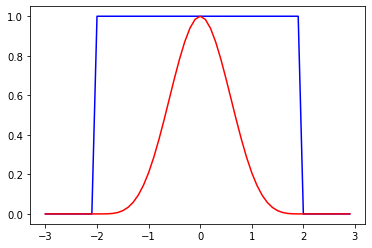

In [9]:
# Définition des fonctions de localisation
def f1(r):
    k = np.zeros(r.shape[0])
    for i in range(r.shape[0]):
        if np.abs(r[i]) >= 0 and np.abs(r[i]) <= 2:
            k[i] = 1
    return k

def f2(r):
    k = np.zeros(r.shape[0])
    for i in range(r.shape[0]):
        r_abs = np.abs(r[i])
        if 0 <= r_abs <= 1:
            k[i] =  1 -(5/3)*(r_abs**2) + (5/8)*(r_abs**3) + (1/2)*(r_abs**4) -(1/4)*(r_abs**5)
        elif 1<= r_abs <= 2:
            k[i] = (-2/3)*(r_abs**(-1)) + 4 - 5*r_abs + (5/3)*(r_abs**2) + (5/8)*(r_abs**3) - (1/2)*(r_abs**4) + (1/12)*(r_abs**5)
    return k

x = np.arange(-3., 3., 0.1)  # z/c
plt.plot(x,f1(x),'b',x, f2(x),'r')

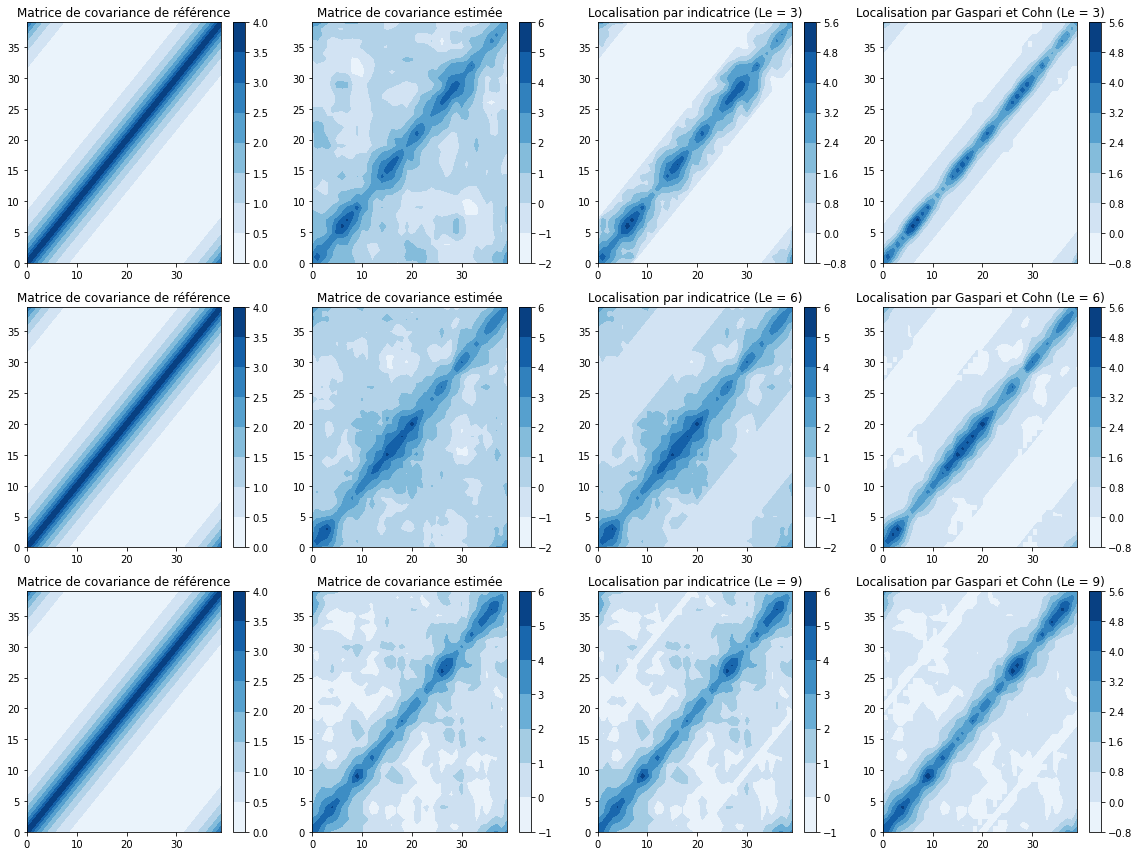

In [19]:
Le_values = [3, 6, 9] 

fig, axes = plt.subplots(len(Le_values), 4, figsize=(16, len(Le_values) * 4))

for idx, Le in enumerate(Le_values):
    rho1 = np.zeros((n_grid, n_grid))  #f1
    rho2 = np.zeros((n_grid, n_grid))  #f2

    for i in range(n_grid):
        for j in range(n_grid):
            num = np.abs(x_grid[i] - x_grid[j])
            rho1[i, j] = f1(np.array([np.minimum(num, L_grid - num) / Le]))[0]
            rho2[i, j] = f2(np.array([np.minimum(num, L_grid - num) / Le]))[0]


    # Localisation de Pe
    Nens=50
    Pe=compute_Pe(Nens) 

    ## TO DO ##        
    Pe_loc1=np.multiply(rho1,Pe)
    Pe_loc2=np.multiply(rho2,Pe)
    ## END TO DO ##

    # Affichage

    
    im = axes[idx, 0].contourf(X, Y, Pt, cmap=cm.Blues)
    axes[idx, 0].set_title(f'Matrice de covariance de référence')
    fig.colorbar(im, ax=axes[idx, 0])

    im = axes[idx, 1].contourf(X, Y, Pe, cmap=cm.Blues)
    axes[idx, 1].set_title(f'Matrice de covariance estimée')
    fig.colorbar(im, ax=axes[idx, 1])

    im = axes[idx, 2].contourf(X, Y, Pe_loc1, cmap=cm.Blues)
    axes[idx, 2].set_title(f'Localisation par indicatrice (Le = {Le})')
    fig.colorbar(im, ax=axes[idx, 2])

    im = axes[idx, 3].contourf(X, Y, Pe_loc2, cmap=cm.Blues)
    axes[idx, 3].set_title(f'Localisation par Gaspari et Cohn (Le = {Le})')
    fig.colorbar(im, ax=axes[idx, 3])

plt.tight_layout()
plt.show()

In [6]:
np.min(Pe_loc1), np.max(Pe_loc1), np.min(Pe_loc2), np.max(Pe_loc2)

(-0.8253491515920417,
 6.532636118390705,
 -0.007254582137316086,
 6.532636118390705)

**Pour aller plus loin** 

DAPPER une librairie python pour l'assimilation de données : https://github.com/nansencenter/DAPPER
